In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
import lightgbm as lgb
%matplotlib inline

import warnings
warnings.simplefilter('ignore')

In [343]:
#データのダウンロード
train_data = pd.read_csv('csv/train.csv', index_col=0)
test_data = pd.read_csv('csv/test.csv', index_col=0)
sample_submit = pd.read_csv('csv/sample_submission.csv', index_col=0, header=None)

In [344]:
train_data.head()

,created_at,tree_dbh,curb_loc,health,steward,guards,sidewalk,user_type,problems,spc_common,...,nta,nta_name,borocode,boro_ct,boroname,zip_city,cb_num,st_senate,st_assem,cncldist
0,2015-06-29,14,OnCurb,1,NaN,NaN,Damage,Volunteer,NaN,English oak,...,QN45,Douglas Manor-Douglaston-Little Neck,4,4152901,Queens,Little Neck,411,11,25,23
1,2016-09-21,5,OnCurb,1,3or4,Helpful,NoDamage,Volunteer,NaN,crimson king maple,...,BX05,Bedford Park-Fordham North,2,2039901,Bronx,Bronx,207,33,78,15
2,2015-09-13,26,OnCurb,2,NaN,NaN,NoDamage,Volunteer,StonesBranchLights,English oak,...,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,5,5017011,Staten Island,Staten Island,503,24,62,51
3,2016-05-09,15,OnCurb,0,NaN,NaN,Damage,NYC Parks Staff,NaN,honeylocust,...,SI11,Charleston-Richmond Valley-Tottenville,5,5024401,Staten Island,Staten Island,503,24,62,51
4,2016-06-24,23,OnCurb,1,NaN,NaN,NoDamage,Volunteer,Stones,London planetree,...,MN03,Central Harlem North-Polo Grounds,1,1022102,Manhattan,New York,110,30,70,9


In [322]:
#訓練データのデータ、特徴量数
train_data.shape

(19984, 21)

In [345]:
train_df = train_data.copy()
test_df = test_data.copy()

In [346]:
"""
不均衡データ
"""
train_df['health'].value_counts().sort_index()

health
0     3535
1    15751
2      698
Name: count, dtype: int64

<BarContainer object of 3 artists>

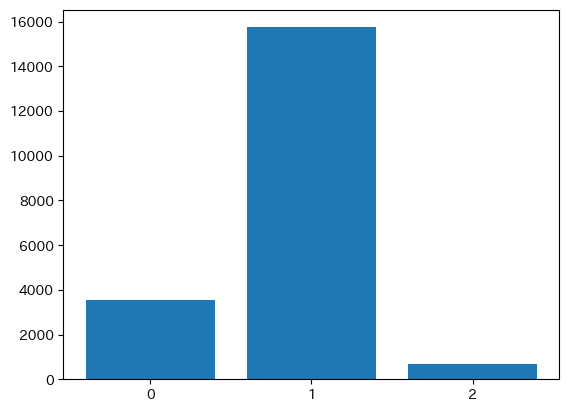

In [347]:
health_counts = train_df['health'].value_counts().sort_index()
plt.bar(['0', '1', '2'], health_counts.values)

In [348]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19984 entries, 0 to 19983
Data columns (total 21 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  19984 non-null  object
 1   tree_dbh    19984 non-null  int64 
 2   curb_loc    19984 non-null  object
 3   health      19984 non-null  int64 
 4   steward     5101 non-null   object
 5   guards      5041 non-null   object
 6   sidewalk    19984 non-null  object
 7   user_type   19984 non-null  object
 8   problems    7741 non-null   object
 9   spc_common  19984 non-null  object
 10  spc_latin   19984 non-null  object
 11  nta         19984 non-null  object
 12  nta_name    19984 non-null  object
 13  borocode    19984 non-null  int64 
 14  boro_ct     19984 non-null  int64 
 15  boroname    19984 non-null  object
 16  zip_city    19984 non-null  object
 17  cb_num      19984 non-null  int64 
 18  st_senate   19984 non-null  int64 
 19  st_assem    19984 non-null  int64 
 20  cncldist   

In [349]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19702 entries, 19984 to 39968
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   created_at  19702 non-null  object
 1   tree_dbh    19702 non-null  int64 
 2   curb_loc    19702 non-null  object
 3   steward     5176 non-null   object
 4   guards      5135 non-null   object
 5   sidewalk    19702 non-null  object
 6   user_type   19702 non-null  object
 7   problems    7657 non-null   object
 8   spc_common  19702 non-null  object
 9   spc_latin   19702 non-null  object
 10  nta         19702 non-null  object
 11  nta_name    19702 non-null  object
 12  borocode    19702 non-null  int64 
 13  boro_ct     19702 non-null  int64 
 14  boroname    19702 non-null  object
 15  zip_city    19702 non-null  object
 16  cb_num      19702 non-null  int64 
 17  st_senate   19702 non-null  int64 
 18  st_assem    19702 non-null  int64 
 19  cncldist    19702 non-null  int64 
dtypes: int6

In [350]:
#各特徴量の欠損値数
train_df.isnull().sum()

created_at        0
tree_dbh          0
curb_loc          0
health            0
steward       14883
guards        14943
sidewalk          0
user_type         0
problems      12243
spc_common        0
spc_latin         0
nta               0
nta_name          0
borocode          0
boro_ct           0
boroname          0
zip_city          0
cb_num            0
st_senate         0
st_assem          0
cncldist          0
dtype: int64

In [351]:
test_df.isnull().sum()

created_at        0
tree_dbh          0
curb_loc          0
steward       14526
guards        14567
sidewalk          0
user_type         0
problems      12045
spc_common        0
spc_latin         0
nta               0
nta_name          0
borocode          0
boro_ct           0
boroname          0
zip_city          0
cb_num            0
st_senate         0
st_assem          0
cncldist          0
dtype: int64

In [330]:
#欠損値を含む特徴量のデータ確認
print(train_df['steward'].value_counts())
print('-'*30)
print(train_df['guards'].value_counts())
print('-'*30)
print(train_df['problems'].value_counts())
print('-'*30)
print('problemsのユニークデータ数')
train_df['problems'].unique().shape[0]

steward
1or2       3999
3or4       1079
4orMore      23
Name: count, dtype: int64
------------------------------
guards
Helpful    3650
Unsure      737
Harmful     654
Name: count, dtype: int64
------------------------------
problems
Stones                                  2219
BranchLights                            1036
StonesBranchLights                       762
BranchOther                              408
RootOther                                333
                                        ... 
StonesRootOtherTrunkOtherBranchOther       8
StonesRootOtherWiresRopeBranchOther        5
StonesMetalGratesTrunkOther                4
TrunkLightsBranchLightsBranchOther         4
WiresRopeTrunkLightsBranchLights           4
Name: count, Length: 73, dtype: int64
------------------------------
problemsのユニークデータ数


74

In [331]:
#----テストデーターーーーー
print(test_df['steward'].value_counts())
print('-'*30)
print(test_df['guards'].value_counts())
print('-'*30)
print(test_df['problems'].value_counts())
print('-'*30)
print('problemsのユニークデータ数')
test_df['problems'].unique().shape[0]

steward
1or2       4165
3or4        989
4orMore      22
Name: count, dtype: int64
------------------------------
guards
Helpful    3716
Unsure      753
Harmful     666
Name: count, dtype: int64
------------------------------
problems
Stones                                  2236
BranchLights                            1009
StonesBranchLights                       767
BranchOther                              385
RootOther                                384
                                        ... 
StonesRootOtherTrunkOtherBranchOther       7
WiresRopeTrunkLights                       6
StonesTrunkLightsBranchLights              6
WiresRopeTrunkLightsBranchLights           5
RootOtherWiresRopeTrunkLights              4
Name: count, Length: 73, dtype: int64
------------------------------
problemsのユニークデータ数


74

In [332]:
#欠損値をNULLに置き換え
train_df.fillna('NULL', inplace=True)
test_df.fillna('NULL', inplace=True)
print('-'*30 + '↓トレーニングデータ')
print(train_df.isnull().sum())
print('-'*30 + '↓テストデータ')
print(test_df.isnull().sum())

------------------------------↓トレーニングデータ
created_at    0
tree_dbh      0
curb_loc      0
health        0
steward       0
guards        0
sidewalk      0
user_type     0
problems      0
spc_common    0
spc_latin     0
nta           0
nta_name      0
borocode      0
boro_ct       0
boroname      0
zip_city      0
cb_num        0
st_senate     0
st_assem      0
cncldist      0
dtype: int64
------------------------------↓テストデータ
created_at    0
tree_dbh      0
curb_loc      0
steward       0
guards        0
sidewalk      0
user_type     0
problems      0
spc_common    0
spc_latin     0
nta           0
nta_name      0
borocode      0
boro_ct       0
boroname      0
zip_city      0
cb_num        0
st_senate     0
st_assem      0
cncldist      0
dtype: int64


In [333]:
#problemを問題あり、なしのバイナリデータに変換
train_df['bool_problems'] = train_df['problems'].apply(lambda x: 0 if x == 'NULL' else 1)
test_df['bool_problems'] = test_df['problems'].apply(lambda x: 0 if x == 'NULL' else 1)

In [334]:
train_df[['bool_problems', 'problems']].head(10)

,bool_problems,problems
0,0,NULL
1,0,NULL
2,1,StonesBranchLights
3,0,NULL
4,1,Stones
5,0,NULL
6,1,BranchLights
7,0,NULL
8,0,NULL
9,1,Stones


In [335]:
test_df[['bool_problems', 'problems']].head(10)

,bool_problems,problems
19984,0,NULL
19985,0,NULL
19986,0,NULL
19987,0,NULL
19988,1,Stones
19989,0,NULL
19990,0,NULL
19991,1,Stones
19992,1,StonesRootOtherTrunkOther
19993,1,RootOther


In [340]:
#必要な特徴量を選抜
no_select_cols = ['created_at', 'spc_latin', 'nta_name','boroname']
corr_drop_cols = ['boro_ct', 'cb_num', 'st_assem', 'zip_city']

val_df = train_df.pop('health')
select_train_df = train_df.drop(no_select_cols + corr_drop_cols, axis=1)
select_test_df = test_df.drop(no_select_cols + corr_drop_cols, axis=1)

In [341]:
select_train_df.head()

,tree_dbh,curb_loc,steward,guards,sidewalk,user_type,problems,spc_common,nta,borocode,st_senate,cncldist,bool_problems
0,14,OnCurb,NULL,NULL,Damage,Volunteer,NULL,English oak,QN45,4,11,23,0
1,5,OnCurb,3or4,Helpful,NoDamage,Volunteer,NULL,crimson king maple,BX05,2,33,15,0
2,26,OnCurb,NULL,NULL,NoDamage,Volunteer,StonesBranchLights,English oak,SI01,5,24,51,1
3,15,OnCurb,NULL,NULL,Damage,NYC Parks Staff,NULL,honeylocust,SI11,5,24,51,0
4,23,OnCurb,NULL,NULL,NoDamage,Volunteer,Stones,London planetree,MN03,1,30,9,1


In [497]:
select_train_df.dtypes

tree_dbh           int64
curb_loc         float64
steward          float64
guards           float64
sidewalk         float64
user_type        float64
problems         float64
spc_common       float64
nta              float64
borocode         float64
st_senate        float64
cncldist         float64
bool_problems      int64
dtype: object

In [495]:
select_test_df.dtypes

tree_dbh           int64
curb_loc         float64
steward          float64
guards           float64
sidewalk         float64
user_type        float64
problems         float64
spc_common       float64
nta              float64
borocode         float64
st_senate        float64
cncldist         float64
bool_problems      int64
dtype: object

In [357]:
#OrdinalEncodeのために数値コードのものをObject化

def label_coding(train, test, cols):
    
    #ラベルのintカラムをobjectへ変換
    train[cols] = train[cols].astype(str)
    test[cols] = test[cols].astype(str)

    #object型の特徴量を抽出
    object_train_df = train.loc[:, train.dtypes == 'object']
    object_test_df = test.loc[:, test.dtypes == 'object']

    #ラベルエンコード

    #抽出したobjectの名前と空のdf
    extra_col = object_train_df.columns
    label_train_df = pd.DataFrame()
    label_test_df = pd.DataFrame(index=test.index)

    #ラベルエンコード
    oe = OrdinalEncoder()
    label_train_df[extra_col] = oe.fit_transform(object_train_df)
    label_test_df[extra_col] = oe.transform(object_test_df)
    label_test_df[extra_col] = oe.transform(object_test_df)


    # #ラベルエンコードしたデータに置き換え
    select_train_df[extra_col] = label_train_df
    select_test_df[extra_col] = label_test_df
    
    return select_train_df, select_test_df


int_labels =['borocode','st_senate', 'cncldist']
select_train_df, select_test_df = label_coding(select_train_df, select_test_df, int_labels)

<Axes: >

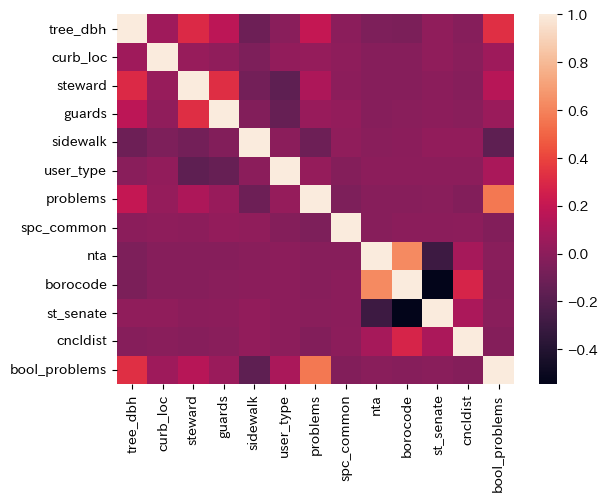

In [358]:
sns.heatmap(select_train_df.corr())

<Axes: >

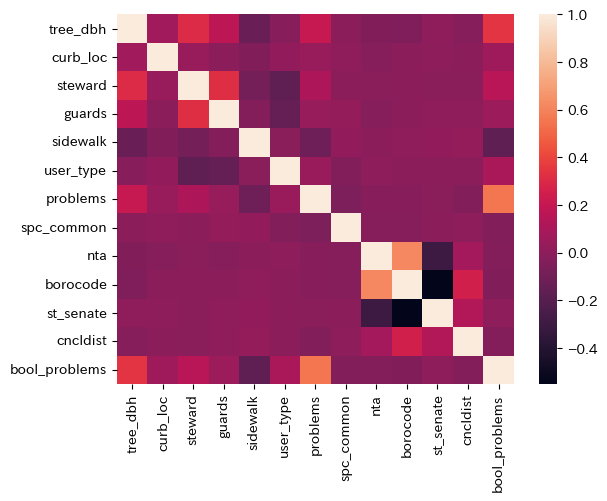

In [359]:
sns.heatmap(select_test_df.corr())

## サンダーサンプリング

In [295]:
#healthカラムをtrain_dfに戻す
select_train_df['health'] = val_df

In [298]:
#アンダーサンプリング
from imblearn.under_sampling import RandomUnderSampler


def under_sampling(train, target_col, random_state=42):
    random_state = random_state
    rs = RandomUnderSampler(random_state=random_state)
    under_sampling, _ = rs.fit_resample(train, train[target])
    
    return under_sampling

target = 'health'
under_train_df = under_sampling(select_train_df, target)
under_test_df = under_train_df.pop('health')

## ここから機械学習

In [362]:
#説明変数をx、目的変数をyに格納
X = select_train_df
y = val_df

In [363]:
#データの分割

seed=42
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=0)

train_data = lgb.Dataset(X_train, label=y_train)
eval_data = lgb.Dataset(X_eval, label=y_eval, reference=train_data)

## チューニング前のモデル確認

In [34]:
#パラメータチューニングに使用


#チューニング対象外のパラメータ
# params = {
#     'objective':'multiclass',
#     'metric':'multi_logloss',
#     'random_state':seed,
#     'boosting_type':'gbdt',
#     'n_estimators':10000,
#     'verbose':-1,
#     'early_stopping_round':10
# }

# model = lgb.LGBMClassifier(**params)


# fit_params = {
#     'eval_set':[(X_eval, y_eval)]
# }

# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1, fit_params=fit_params)

In [368]:
params = {
    'task':'train',
    'boosting_type':'gbdt',
    'objective':'multiclass',
    'metric':'multi_logloss',
    'n_estimators':10000,
    'num_class':3,
} 


evals_result = {} 

model = lgb.train(
    params,
    train_data,
    valid_sets=eval_data,
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=10),  lgb.record_evaluation(evals_result)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 13988, number of used features: 13
[LightGBM] [Info] Start training from score -1.737226
[LightGBM] [Info] Start training from score -0.238307
[LightGBM] [Info] Start training from score -3.323379
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's multi_logloss: 0.603513


f1_score_score:0.293954933954934
accuracy_score:0.7886924616410941
precision_score:0.26289748721369804
recall_score:0.3333333333333333


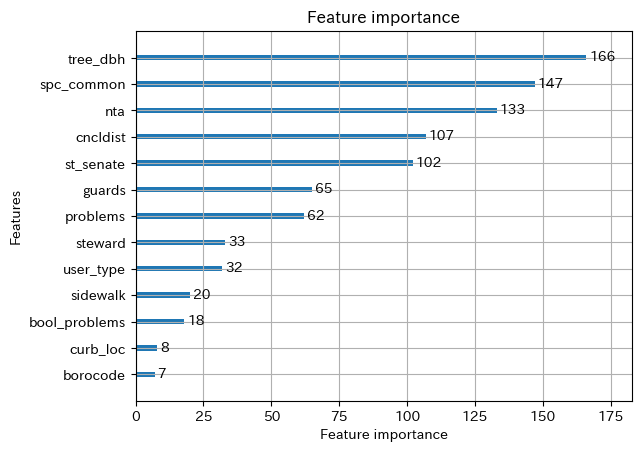

In [369]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

def scores(model, X_eval, y_eval):
    
    #モデルの予測
    y_pred =  model.predict(X_eval)

    #最高確率のラベル抽出
    result = []
    for i in y_pred:
        result.append(np.argmax(i))

    
    print('f1_score_score:{}'.format(f1_score(y_eval, result, average='macro')))
    print('accuracy_score:{}'.format(accuracy_score(y_eval, result)))    
    print('precision_score:{}'.format(precision_score(y_eval, result, average='macro')))    
    print('recall_score:{}'.format(recall_score(y_eval, result, average='macro')))
    lgb.plot_importance(model)
    lgb.plot_metric(evals_result)

    
scores(model, X_eval, y_eval)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

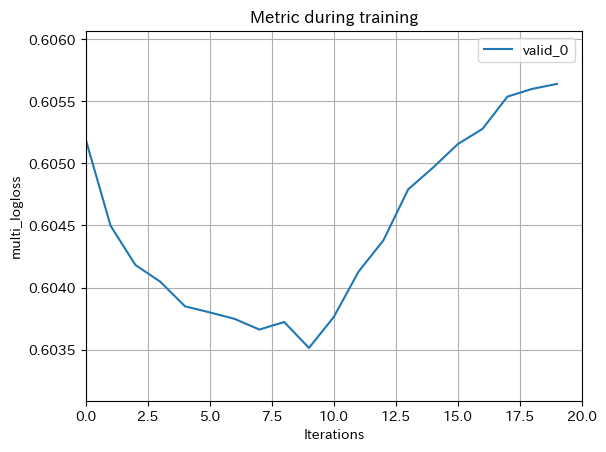

In [371]:
lgb.plot_metric(evals_result)

In [386]:
#提出用データの加工

def submit_pross(model, test_data):
    sample_submit = pd.read_csv('csv/sample_submission.csv', index_col=0, header=None)
    pred_proba =  model.predict(select_test_df)
    
    #最高確率のラベル抽出
    pred = []
    for i in pred_proba:
        pred.append(np.argmax(i))
        
    sample_submit[1] = pred
    sample_submit.to_csv('/work/submit.csv', header=None)

## 重み付け

参考　＝＞https://qiita.com/Dixhom/items/fd78f461d038798a7e2e#weight%E3%82%AA%E3%83%97%E3%82%B7%E3%83%A7%E3%83%B3%E3%81%AE%E8%A8%AD%E5%AE%9A

In [416]:
from sklearn.utils.class_weight import compute_sample_weight

#参照データ
X = select_train_df
y = val_df

#データ分割
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=0)


#lihgtGBMでの重み付け
train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
weighted_train = lgb.Dataset(X_train, y_train, weight=train_weight)
weighted_test = lgb.Dataset(X_eval, label=y_eval, reference=lgb_train)

In [417]:
params = {
    'task':'train',
    'boosting_type':'gbdt',
    'objective':'multiclass',
    'metric':'multi_logloss',
    'n_estimators':10000,
    'num_class':3,
} 


evals_result = {} 

model = lgb.train(
    params,
    weighted_train,
    valid_sets=weighted_test,
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=10),  lgb.record_evaluation(evals_result)])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027251 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 13988, number of used features: 13
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[538]	valid_0's multi_logloss: 0.817484


f1_score_score:0.3376707343812468
accuracy_score:0.6209139426284189
precision_score:0.33890634425226884
recall_score:0.3402104575514259


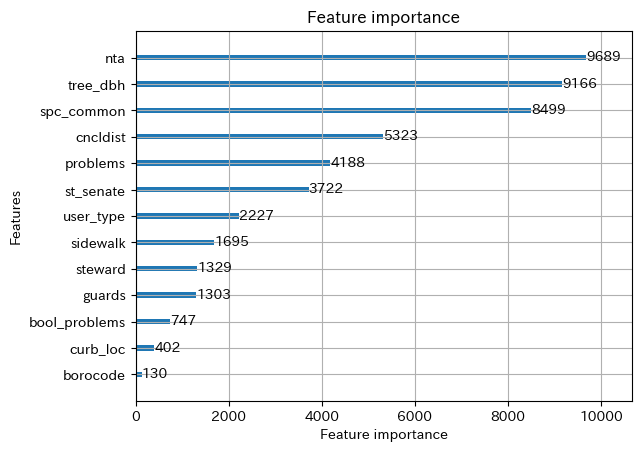

In [382]:
scores(model, X_eval, y_eval)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='multi_logloss'>

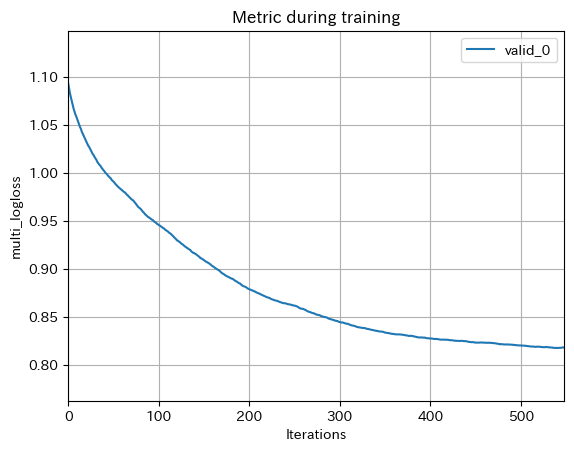

In [392]:
lgb.plot_metric(evals_result)

In [388]:
submit_pross(model, select_test_df)

## lightGBMのパラメーターチューニング

In [397]:
# from lightgbm import LGBMClassifier

# #投稿用ではf1_scoreが評価されるので
# scoring = 'f1_macro'
# seed = 42 





# #不均衡データなので層化KFoldを使用
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)


# # 学習時のfitパラメータ
# fit_params = {'eval_set':[X_eval, y_eval]}

# #クロスバリデーションの評価指標算出
# scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1, fit_params=fit_params)

# print(f'scores={scores}')
# print(f'average_score = {np.mean(scores)}')

## optunaをパラメータチューニングに使用してみる

In [486]:
from optuna.integration import lightgbm as lgbo
import time

start_ts = time.time() 


#lihgtGBMでの重み付け
train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
lgb_train = lgbo.Dataset(X_train, y_train, weight=train_weight)
lgb_test = lgbo.Dataset(X_eval, label=y_eval, reference=lgb_train)

# mult_logloss
params = {
    'boosting_type':'gbdt',
    'objective':'multiclass',
    'metric':'multi_logloss',
    'num_class':3,
    'verbose':-1
} 

#mult_erorr
# params = {
#     'boosting_type':'gbdt',
#     'objective':'multiclass',
#     'metric':'multi_error',
#     'num_class':3,
#     'verbose':-1
# } 


evals_result = {} 

pre_model = lgbo.train(
    params,
    lgb_train,
    valid_sets=lgb_test,
    callbacks=[lgb.early_stopping(stopping_rounds=100)])

tooked_time = time.time() - start_ts
print(tooked_time)

[I 2023-12-28 15:24:45,202] A new study created in memory with name: no-name-5494fa75-b743-4bbd-99da-c970901df767

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.820785:  14%|#4        | 1/7 [00:03<00:19,  3.21s/it][I 2023-12-28 15:24:48,434] Trial 0 finished with value: 0.8207852902905791 and parameters: {'feature_fraction': 0.6}. Best is trial 0 with value: 0.8207852902905791.

feature_fraction, val_score: 0.820785:  14%|#4        | 1/7 [00:03<00:19,  3.21s/it]

Early stopping, best iteration is:
[561]	valid_0's multi_logloss: 0.820785
Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.820785:  29%|##8       | 2/7 [00:05<00:14,  2.90s/it][I 2023-12-28 15:24:51,124] Trial 1 finished with value: 0.8235264943569656 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 0 with value: 0.8207852902905791.

feature_fraction, val_score: 0.820785:  29%|##8       | 2/7 [00:05<00:14,  2.90s/it]

Early stopping, best iteration is:
[535]	valid_0's multi_logloss: 0.823526
Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.820785:  43%|####2     | 3/7 [00:09<00:12,  3.13s/it][I 2023-12-28 15:24:54,535] Trial 2 finished with value: 0.8234804042547201 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.8207852902905791.

feature_fraction, val_score: 0.820785:  43%|####2     | 3/7 [00:09<00:12,  3.13s/it]

Early stopping, best iteration is:
[594]	valid_0's multi_logloss: 0.82348
Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.820785:  57%|#####7    | 4/7 [00:12<00:09,  3.30s/it][I 2023-12-28 15:24:58,091] Trial 3 finished with value: 0.8362726218823001 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.8207852902905791.

feature_fraction, val_score: 0.820785:  57%|#####7    | 4/7 [00:12<00:09,  3.30s/it]

Early stopping, best iteration is:
[632]	valid_0's multi_logloss: 0.836273
Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.820785:  71%|#######1  | 5/7 [00:16<00:06,  3.26s/it][I 2023-12-28 15:25:01,286] Trial 4 finished with value: 0.8216250435412593 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.8207852902905791.

feature_fraction, val_score: 0.820785:  71%|#######1  | 5/7 [00:16<00:06,  3.26s/it]

Early stopping, best iteration is:
[595]	valid_0's multi_logloss: 0.821625
Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.816161:  86%|########5 | 6/7 [00:19<00:03,  3.31s/it][I 2023-12-28 15:25:04,680] Trial 5 finished with value: 0.8161608416581094 and parameters: {'feature_fraction': 0.7}. Best is trial 5 with value: 0.8161608416581094.

feature_fraction, val_score: 0.816161:  86%|########5 | 6/7 [00:19<00:03,  3.31s/it]

Early stopping, best iteration is:
[552]	valid_0's multi_logloss: 0.816161
Training until validation scores don't improve for 100 rounds



feature_fraction, val_score: 0.816161: 100%|##########| 7/7 [00:21<00:00,  3.14s/it]


Early stopping, best iteration is:
[519]	valid_0's multi_logloss: 0.820642



num_leaves, val_score: 0.816161:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.801612:   5%|5         | 1/20 [00:02<00:47,  2.51s/it][I 2023-12-28 15:25:09,693] Trial 7 finished with value: 0.8016115303187954 and parameters: {'num_leaves': 55}. Best is trial 7 with value: 0.8016115303187954.

num_leaves, val_score: 0.801612:   5%|5         | 1/20 [00:02<00:47,  2.51s/it]

Early stopping, best iteration is:
[338]	valid_0's multi_logloss: 0.801612
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.794985:  10%|#         | 2/20 [00:05<00:50,  2.80s/it][I 2023-12-28 15:25:12,699] Trial 8 finished with value: 0.7949850398687596 and parameters: {'num_leaves': 95}. Best is trial 8 with value: 0.7949850398687596.

num_leaves, val_score: 0.794985:  10%|#         | 2/20 [00:05<00:50,  2.80s/it]

Early stopping, best iteration is:
[192]	valid_0's multi_logloss: 0.794985
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.784472:  15%|#5        | 3/20 [00:09<00:53,  3.14s/it][I 2023-12-28 15:25:16,239] Trial 9 finished with value: 0.7844724894481524 and parameters: {'num_leaves': 230}. Best is trial 9 with value: 0.7844724894481524.

num_leaves, val_score: 0.784472:  15%|#5        | 3/20 [00:09<00:53,  3.14s/it]

Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.784472
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777784:  20%|##        | 4/20 [00:13<00:57,  3.60s/it][I 2023-12-28 15:25:20,540] Trial 10 finished with value: 0.7777835514728949 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.7777835514728949.

num_leaves, val_score: 0.777784:  20%|##        | 4/20 [00:13<00:57,  3.60s/it]

Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.777784
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777784:  25%|##5       | 5/20 [00:16<00:53,  3.54s/it][I 2023-12-28 15:25:23,989] Trial 11 finished with value: 0.7777835514728949 and parameters: {'num_leaves': 256}. Best is trial 10 with value: 0.7777835514728949.

num_leaves, val_score: 0.777784:  25%|##5       | 5/20 [00:16<00:53,  3.54s/it]

Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.777784
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777784:  30%|###       | 6/20 [00:20<00:48,  3.50s/it][I 2023-12-28 15:25:27,393] Trial 12 finished with value: 0.7803813292672019 and parameters: {'num_leaves': 248}. Best is trial 10 with value: 0.7777835514728949.

num_leaves, val_score: 0.777784:  30%|###       | 6/20 [00:20<00:48,  3.50s/it]

Early stopping, best iteration is:
[80]	valid_0's multi_logloss: 0.780381
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777784:  35%|###5      | 7/20 [00:23<00:44,  3.41s/it][I 2023-12-28 15:25:30,635] Trial 13 finished with value: 0.7842150290090775 and parameters: {'num_leaves': 183}. Best is trial 10 with value: 0.7777835514728949.

num_leaves, val_score: 0.777784:  35%|###5      | 7/20 [00:23<00:44,  3.41s/it]

Early stopping, best iteration is:
[116]	valid_0's multi_logloss: 0.784215
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777784:  40%|####      | 8/20 [00:26<00:40,  3.37s/it][I 2023-12-28 15:25:33,925] Trial 14 finished with value: 0.7908849274471039 and parameters: {'num_leaves': 170}. Best is trial 10 with value: 0.7777835514728949.

num_leaves, val_score: 0.777784:  40%|####      | 8/20 [00:26<00:40,  3.37s/it]

Early stopping, best iteration is:
[121]	valid_0's multi_logloss: 0.790885
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777077:  45%|####5     | 9/20 [00:30<00:37,  3.44s/it][I 2023-12-28 15:25:37,517] Trial 15 finished with value: 0.7770774126300175 and parameters: {'num_leaves': 255}. Best is trial 15 with value: 0.7770774126300175.

num_leaves, val_score: 0.777077:  45%|####5     | 9/20 [00:30<00:37,  3.44s/it]

Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.777077
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777077:  50%|#####     | 10/20 [00:34<00:36,  3.67s/it][I 2023-12-28 15:25:41,693] Trial 16 finished with value: 0.7858438773704428 and parameters: {'num_leaves': 185}. Best is trial 15 with value: 0.7770774126300175.

num_leaves, val_score: 0.777077:  50%|#####     | 10/20 [00:34<00:36,  3.67s/it]

Early stopping, best iteration is:
[118]	valid_0's multi_logloss: 0.785844
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777077:  55%|#####5    | 11/20 [00:36<00:29,  3.23s/it][I 2023-12-28 15:25:43,929] Trial 17 finished with value: 1.0388999716374816 and parameters: {'num_leaves': 3}. Best is trial 15 with value: 0.7770774126300175.

num_leaves, val_score: 0.777077:  55%|#####5    | 11/20 [00:36<00:29,  3.23s/it]

Did not meet early stopping. Best iteration is:
[1000]	valid_0's multi_logloss: 1.0389
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777077:  60%|######    | 12/20 [00:39<00:25,  3.21s/it][I 2023-12-28 15:25:47,101] Trial 18 finished with value: 0.7878987834139349 and parameters: {'num_leaves': 205}. Best is trial 15 with value: 0.7770774126300175.

num_leaves, val_score: 0.777077:  60%|######    | 12/20 [00:39<00:25,  3.21s/it]

Early stopping, best iteration is:
[87]	valid_0's multi_logloss: 0.787899
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777077:  65%|######5   | 13/20 [00:42<00:21,  3.14s/it][I 2023-12-28 15:25:50,083] Trial 19 finished with value: 0.7948789474748164 and parameters: {'num_leaves': 120}. Best is trial 15 with value: 0.7770774126300175.

num_leaves, val_score: 0.777077:  65%|######5   | 13/20 [00:42<00:21,  3.14s/it]

Early stopping, best iteration is:
[153]	valid_0's multi_logloss: 0.794879
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777077:  70%|#######   | 14/20 [00:46<00:19,  3.17s/it][I 2023-12-28 15:25:53,331] Trial 20 finished with value: 0.7877315080228364 and parameters: {'num_leaves': 148}. Best is trial 15 with value: 0.7770774126300175.

num_leaves, val_score: 0.777077:  70%|#######   | 14/20 [00:46<00:19,  3.17s/it]

Early stopping, best iteration is:
[127]	valid_0's multi_logloss: 0.787732
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777077:  75%|#######5  | 15/20 [00:50<00:17,  3.42s/it][I 2023-12-28 15:25:57,330] Trial 21 finished with value: 0.7812114336235865 and parameters: {'num_leaves': 247}. Best is trial 15 with value: 0.7770774126300175.

num_leaves, val_score: 0.777077:  75%|#######5  | 15/20 [00:50<00:17,  3.42s/it]

Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.781211
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777077:  80%|########  | 16/20 [00:53<00:14,  3.53s/it][I 2023-12-28 15:26:01,094] Trial 22 finished with value: 0.7777835514728949 and parameters: {'num_leaves': 256}. Best is trial 15 with value: 0.7770774126300175.

num_leaves, val_score: 0.777077:  80%|########  | 16/20 [00:53<00:14,  3.53s/it]

Early stopping, best iteration is:
[74]	valid_0's multi_logloss: 0.777784
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777077:  85%|########5 | 17/20 [00:57<00:10,  3.58s/it][I 2023-12-28 15:26:04,808] Trial 23 finished with value: 0.7814831545821602 and parameters: {'num_leaves': 217}. Best is trial 15 with value: 0.7770774126300175.

num_leaves, val_score: 0.777077:  85%|########5 | 17/20 [00:57<00:10,  3.58s/it]

Early stopping, best iteration is:
[86]	valid_0's multi_logloss: 0.781483
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777077:  90%|######### | 18/20 [01:01<00:07,  3.74s/it][I 2023-12-28 15:26:08,899] Trial 24 finished with value: 0.7853810272744255 and parameters: {'num_leaves': 215}. Best is trial 15 with value: 0.7770774126300175.

num_leaves, val_score: 0.777077:  90%|######### | 18/20 [01:01<00:07,  3.74s/it]

Early stopping, best iteration is:
[93]	valid_0's multi_logloss: 0.785381
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777077:  95%|#########5| 19/20 [01:06<00:04,  4.13s/it][I 2023-12-28 15:26:13,949] Trial 25 finished with value: 0.7788802904935229 and parameters: {'num_leaves': 254}. Best is trial 15 with value: 0.7770774126300175.

num_leaves, val_score: 0.777077:  95%|#########5| 19/20 [01:06<00:04,  4.13s/it]

Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.77888
Training until validation scores don't improve for 100 rounds



num_leaves, val_score: 0.777077: 100%|##########| 20/20 [01:10<00:00,  3.53s/it]


Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.782048



bagging, val_score: 0.777077:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds



bagging, val_score: 0.777077:  10%|#         | 1/10 [00:03<00:31,  3.51s/it][I 2023-12-28 15:26:21,378] Trial 27 finished with value: 0.8253577232958726 and parameters: {'bagging_fraction': 0.4080357299551419, 'bagging_freq': 7}. Best is trial 27 with value: 0.8253577232958726.

bagging, val_score: 0.777077:  10%|#         | 1/10 [00:03<00:31,  3.51s/it]

Early stopping, best iteration is:
[91]	valid_0's multi_logloss: 0.825358
Training until validation scores don't improve for 100 rounds



bagging, val_score: 0.775332:  20%|##        | 2/10 [00:07<00:31,  3.99s/it][I 2023-12-28 15:26:25,712] Trial 28 finished with value: 0.775332046716527 and parameters: {'bagging_fraction': 0.992879386487832, 'bagging_freq': 1}. Best is trial 28 with value: 0.775332046716527.

bagging, val_score: 0.775332:  20%|##        | 2/10 [00:07<00:31,  3.99s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775332
Training until validation scores don't improve for 100 rounds



bagging, val_score: 0.775332:  30%|###       | 3/10 [00:12<00:31,  4.48s/it][I 2023-12-28 15:26:30,762] Trial 29 finished with value: 0.7784636452738686 and parameters: {'bagging_fraction': 0.9849526717365741, 'bagging_freq': 1}. Best is trial 28 with value: 0.775332046716527.

bagging, val_score: 0.775332:  30%|###       | 3/10 [00:12<00:31,  4.48s/it]

Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.778464
Training until validation scores don't improve for 100 rounds



bagging, val_score: 0.775332:  40%|####      | 4/10 [00:17<00:26,  4.45s/it][I 2023-12-28 15:26:35,164] Trial 30 finished with value: 0.777738132180017 and parameters: {'bagging_fraction': 0.9356127747486972, 'bagging_freq': 1}. Best is trial 28 with value: 0.775332046716527.

bagging, val_score: 0.775332:  40%|####      | 4/10 [00:17<00:26,  4.45s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.777738
Training until validation scores don't improve for 100 rounds



bagging, val_score: 0.775332:  50%|#####     | 5/10 [00:20<00:20,  4.12s/it][I 2023-12-28 15:26:38,700] Trial 31 finished with value: 0.7773307850683832 and parameters: {'bagging_fraction': 0.9889309204591329, 'bagging_freq': 1}. Best is trial 28 with value: 0.775332046716527.

bagging, val_score: 0.775332:  50%|#####     | 5/10 [00:20<00:20,  4.12s/it]

Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.777331
Training until validation scores don't improve for 100 rounds



bagging, val_score: 0.775332:  60%|######    | 6/10 [00:25<00:16,  4.20s/it][I 2023-12-28 15:26:43,069] Trial 32 finished with value: 0.7760154147372346 and parameters: {'bagging_fraction': 0.9910399533832279, 'bagging_freq': 1}. Best is trial 28 with value: 0.775332046716527.

bagging, val_score: 0.775332:  60%|######    | 6/10 [00:25<00:16,  4.20s/it]

Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.776015
Training until validation scores don't improve for 100 rounds



bagging, val_score: 0.775332:  70%|#######   | 7/10 [00:29<00:13,  4.35s/it][I 2023-12-28 15:26:47,711] Trial 33 finished with value: 0.7797920467064886 and parameters: {'bagging_fraction': 0.9961013935328856, 'bagging_freq': 1}. Best is trial 28 with value: 0.775332046716527.

bagging, val_score: 0.775332:  70%|#######   | 7/10 [00:29<00:13,  4.35s/it]

Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.779792
Training until validation scores don't improve for 100 rounds



bagging, val_score: 0.775332:  80%|########  | 8/10 [00:34<00:08,  4.41s/it][I 2023-12-28 15:26:52,256] Trial 34 finished with value: 0.77611294620883 and parameters: {'bagging_fraction': 0.9913882394628974, 'bagging_freq': 3}. Best is trial 28 with value: 0.775332046716527.

bagging, val_score: 0.775332:  80%|########  | 8/10 [00:34<00:08,  4.41s/it]

Early stopping, best iteration is:
[69]	valid_0's multi_logloss: 0.776113
Training until validation scores don't improve for 100 rounds



bagging, val_score: 0.775332:  90%|######### | 9/10 [00:38<00:04,  4.47s/it][I 2023-12-28 15:26:56,873] Trial 35 finished with value: 0.7782927257204078 and parameters: {'bagging_fraction': 0.8220520928086898, 'bagging_freq': 4}. Best is trial 28 with value: 0.775332046716527.

bagging, val_score: 0.775332:  90%|######### | 9/10 [00:39<00:04,  4.47s/it]

Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.778293
Training until validation scores don't improve for 100 rounds



bagging, val_score: 0.775332: 100%|##########| 10/10 [00:43<00:00,  4.38s/it]


Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.776111



feature_fraction_stage2, val_score: 0.775332:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds



feature_fraction_stage2, val_score: 0.775332:  17%|#6        | 1/6 [00:04<00:22,  4.60s/it][I 2023-12-28 15:27:06,260] Trial 37 finished with value: 0.775332046716527 and parameters: {'feature_fraction': 0.6839999999999999}. Best is trial 37 with value: 0.775332046716527.

feature_fraction_stage2, val_score: 0.775332:  17%|#6        | 1/6 [00:04<00:22,  4.60s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775332
Training until validation scores don't improve for 100 rounds



feature_fraction_stage2, val_score: 0.775332:  33%|###3      | 2/6 [00:08<00:17,  4.43s/it][I 2023-12-28 15:27:10,576] Trial 38 finished with value: 0.7769109547441989 and parameters: {'feature_fraction': 0.652}. Best is trial 37 with value: 0.775332046716527.

feature_fraction_stage2, val_score: 0.775332:  33%|###3      | 2/6 [00:08<00:17,  4.43s/it]

Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.776911
Training until validation scores don't improve for 100 rounds



feature_fraction_stage2, val_score: 0.775332:  50%|#####     | 3/6 [00:14<00:14,  4.76s/it][I 2023-12-28 15:27:15,741] Trial 39 finished with value: 0.7769109547441989 and parameters: {'feature_fraction': 0.62}. Best is trial 37 with value: 0.775332046716527.

feature_fraction_stage2, val_score: 0.775332:  50%|#####     | 3/6 [00:14<00:14,  4.76s/it]

Early stopping, best iteration is:
[85]	valid_0's multi_logloss: 0.776911
Training until validation scores don't improve for 100 rounds



feature_fraction_stage2, val_score: 0.775332:  67%|######6   | 4/6 [00:18<00:09,  4.52s/it][I 2023-12-28 15:27:19,895] Trial 40 finished with value: 0.7788264514634505 and parameters: {'feature_fraction': 0.7799999999999999}. Best is trial 37 with value: 0.775332046716527.

feature_fraction_stage2, val_score: 0.775332:  67%|######6   | 4/6 [00:18<00:09,  4.52s/it]

Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.778826
Training until validation scores don't improve for 100 rounds



feature_fraction_stage2, val_score: 0.775332:  83%|########3 | 5/6 [00:22<00:04,  4.45s/it][I 2023-12-28 15:27:24,222] Trial 41 finished with value: 0.7788264514634505 and parameters: {'feature_fraction': 0.748}. Best is trial 37 with value: 0.775332046716527.

feature_fraction_stage2, val_score: 0.775332:  83%|########3 | 5/6 [00:22<00:04,  4.45s/it]

Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.778826
Training until validation scores don't improve for 100 rounds



feature_fraction_stage2, val_score: 0.775332: 100%|##########| 6/6 [00:26<00:00,  4.43s/it]


Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775332



regularization_factors, val_score: 0.775332:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775332:   5%|5         | 1/20 [00:04<01:25,  4.52s/it][I 2023-12-28 15:27:32,767] Trial 43 finished with value: 0.7773195551986767 and parameters: {'lambda_l1': 0.022676132279334755, 'lambda_l2': 0.03698842608411402}. Best is trial 43 with value: 0.7773195551986767.

regularization_factors, val_score: 0.775332:   5%|5         | 1/20 [00:04<01:25,  4.52s/it]

Early stopping, best iteration is:
[79]	valid_0's multi_logloss: 0.77732
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775329:  10%|#         | 2/20 [00:09<01:24,  4.72s/it][I 2023-12-28 15:27:37,623] Trial 44 finished with value: 0.7753288897864303 and parameters: {'lambda_l1': 2.7628928426872837e-08, 'lambda_l2': 3.0488000081313384e-08}. Best is trial 44 with value: 0.7753288897864303.

regularization_factors, val_score: 0.775329:  10%|#         | 2/20 [00:09<01:24,  4.72s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775329
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775329:  15%|#5        | 3/20 [00:15<01:30,  5.32s/it][I 2023-12-28 15:27:43,660] Trial 45 finished with value: 0.7753384135945033 and parameters: {'lambda_l1': 1.2424909415986041e-08, 'lambda_l2': 2.0505934333365222e-08}. Best is trial 44 with value: 0.7753288897864303.

regularization_factors, val_score: 0.775329:  15%|#5        | 3/20 [00:15<01:30,  5.32s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775338
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775321:  20%|##        | 4/20 [00:20<01:24,  5.29s/it][I 2023-12-28 15:27:48,909] Trial 46 finished with value: 0.7753207028035122 and parameters: {'lambda_l1': 1.7457508290450786e-08, 'lambda_l2': 1.2527021958695796e-08}. Best is trial 46 with value: 0.7753207028035122.

regularization_factors, val_score: 0.775321:  20%|##        | 4/20 [00:20<01:24,  5.29s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775321
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775321:  25%|##5       | 5/20 [00:25<01:16,  5.12s/it][I 2023-12-28 15:27:53,717] Trial 47 finished with value: 0.7753320465546159 and parameters: {'lambda_l1': 1.6883166535839547e-08, 'lambda_l2': 2.34984220012446e-08}. Best is trial 46 with value: 0.7753207028035122.

regularization_factors, val_score: 0.775321:  25%|##5       | 5/20 [00:25<01:16,  5.12s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775332
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775321:  30%|###       | 6/20 [00:30<01:12,  5.19s/it][I 2023-12-28 15:27:59,051] Trial 48 finished with value: 0.7753288899652907 and parameters: {'lambda_l1': 1.1099472707493021e-08, 'lambda_l2': 1.6533787920757444e-08}. Best is trial 46 with value: 0.7753207028035122.

regularization_factors, val_score: 0.775321:  30%|###       | 6/20 [00:30<01:12,  5.19s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775329
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775321:  35%|###5      | 7/20 [00:37<01:12,  5.57s/it][I 2023-12-28 15:28:05,403] Trial 49 finished with value: 0.7753288899621651 and parameters: {'lambda_l1': 1.3482268575189441e-08, 'lambda_l2': 1.357155838094766e-08}. Best is trial 46 with value: 0.7753207028035122.

regularization_factors, val_score: 0.775321:  35%|###5      | 7/20 [00:37<01:12,  5.57s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775329
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775329



regularization_factors, val_score: 0.775321:  40%|####      | 8/20 [00:41<01:02,  5.18s/it][I 2023-12-28 15:28:09,754] Trial 50 finished with value: 0.7753288899611445 and parameters: {'lambda_l1': 1.3543432567693708e-08, 'lambda_l2': 1.2861644555834442e-08}. Best is trial 46 with value: 0.7753207028035122.

regularization_factors, val_score: 0.775321:  40%|####      | 8/20 [00:41<01:02,  5.18s/it]

Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775321:  45%|####5     | 9/20 [00:46<00:56,  5.10s/it][I 2023-12-28 15:28:14,675] Trial 51 finished with value: 0.7753207028373958 and parameters: {'lambda_l1': 1.1047056030644487e-08, 'lambda_l2': 1.651955190864049e-08}. Best is trial 46 with value: 0.7753207028035122.

regularization_factors, val_score: 0.775321:  45%|####5     | 9/20 [00:46<00:56,  5.10s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775321
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775321:  50%|#####     | 10/20 [00:53<00:58,  5.86s/it][I 2023-12-28 15:28:22,235] Trial 52 finished with value: 0.7753352569207124 and parameters: {'lambda_l1': 1.4291277323002513e-08, 'lambda_l2': 1.920855777261286e-08}. Best is trial 46 with value: 0.7753207028035122.


Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775335



regularization_factors, val_score: 0.775321:  50%|#####     | 10/20 [00:54<00:58,  5.86s/it]

Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775321:  55%|#####5    | 11/20 [01:01<00:58,  6.46s/it][I 2023-12-28 15:28:30,043] Trial 53 finished with value: 0.7753320466581024 and parameters: {'lambda_l1': 1.0214158559505941e-08, 'lambda_l2': 1.2418681886972401e-08}. Best is trial 46 with value: 0.7753207028035122.

regularization_factors, val_score: 0.775321:  55%|#####5    | 11/20 [01:01<00:58,  6.46s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775332
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775329



regularization_factors, val_score: 0.775321:  60%|######    | 12/20 [01:10<00:58,  7.27s/it][I 2023-12-28 15:28:39,191] Trial 54 finished with value: 0.7753288899950922 and parameters: {'lambda_l1': 1.16177810397726e-08, 'lambda_l2': 1.0316177202814737e-08}. Best is trial 46 with value: 0.7753207028035122.

regularization_factors, val_score: 0.775321:  60%|######    | 12/20 [01:10<00:58,  7.27s/it]

Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775321:  65%|######5   | 13/20 [01:16<00:46,  6.71s/it][I 2023-12-28 15:28:44,585] Trial 55 finished with value: 0.7753288898354429 and parameters: {'lambda_l1': 3.051534917824567e-08, 'lambda_l2': 1.0750994041875032e-08}. Best is trial 46 with value: 0.7753207028035122.

regularization_factors, val_score: 0.775321:  65%|######5   | 13/20 [01:16<00:46,  6.71s/it]

Early stopping, best iteration is:
[78]	valid_0's multi_logloss: 0.775329
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775153:  70%|#######   | 14/20 [01:20<00:36,  6.07s/it][I 2023-12-28 15:28:49,173] Trial 56 finished with value: 0.7751529957200277 and parameters: {'lambda_l1': 7.031599776222319e-07, 'lambda_l2': 6.774272430312586e-07}. Best is trial 56 with value: 0.7751529957200277.

regularization_factors, val_score: 0.775153:  70%|#######   | 14/20 [01:20<00:36,  6.07s/it]

Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.775153
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775153:  75%|#######5  | 15/20 [01:24<00:26,  5.40s/it][I 2023-12-28 15:28:53,009] Trial 57 finished with value: 0.7751528898483397 and parameters: {'lambda_l1': 9.824732325586358e-07, 'lambda_l2': 9.057100262750118e-07}. Best is trial 57 with value: 0.7751528898483397.

regularization_factors, val_score: 0.775153:  75%|#######5  | 15/20 [01:24<00:26,  5.40s/it]

Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.775153
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775153:  80%|########  | 16/20 [01:30<00:22,  5.50s/it][I 2023-12-28 15:28:58,772] Trial 58 finished with value: 0.7751528895537844 and parameters: {'lambda_l1': 1.1835164486232256e-06, 'lambda_l2': 1.4084248932129736e-06}. Best is trial 58 with value: 0.7751528895537844.

regularization_factors, val_score: 0.775153:  80%|########  | 16/20 [01:30<00:22,  5.50s/it]

Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.775153
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775150:  85%|########5 | 17/20 [01:35<00:16,  5.44s/it][I 2023-12-28 15:29:04,068] Trial 59 finished with value: 0.7751501516376054 and parameters: {'lambda_l1': 2.08881405461072e-06, 'lambda_l2': 1.1993476421554264e-06}. Best is trial 59 with value: 0.7751501516376054.

regularization_factors, val_score: 0.775150:  85%|########5 | 17/20 [01:35<00:16,  5.44s/it]

Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.77515
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775150:  90%|######### | 18/20 [01:40<00:10,  5.30s/it][I 2023-12-28 15:29:09,023] Trial 60 finished with value: 0.7751516587016636 and parameters: {'lambda_l1': 1.5356057992652693e-06, 'lambda_l2': 1.5359841948286905e-06}. Best is trial 59 with value: 0.7751501516376054.

regularization_factors, val_score: 0.775150:  90%|######### | 18/20 [01:40<00:10,  5.30s/it]

Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.775152
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775150:  95%|#########5| 19/20 [01:44<00:04,  4.94s/it][I 2023-12-28 15:29:13,138] Trial 61 finished with value: 0.7751662321357986 and parameters: {'lambda_l1': 9.664501991647147e-07, 'lambda_l2': 1.1487781760779088e-06}. Best is trial 59 with value: 0.7751501516376054.

regularization_factors, val_score: 0.775150:  95%|#########5| 19/20 [01:44<00:04,  4.94s/it]

Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.775166
Training until validation scores don't improve for 100 rounds



regularization_factors, val_score: 0.775150: 100%|##########| 20/20 [01:52<00:00,  5.62s/it]


Early stopping, best iteration is:
[73]	valid_0's multi_logloss: 0.777137



min_child_samples, val_score: 0.775150:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds



min_child_samples, val_score: 0.775150:  20%|##        | 1/5 [00:04<00:17,  4.28s/it][I 2023-12-28 15:29:24,977] Trial 63 finished with value: 0.7823761199704427 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.7823761199704427.

min_child_samples, val_score: 0.775150:  20%|##        | 1/5 [00:04<00:17,  4.28s/it]

Early stopping, best iteration is:
[71]	valid_0's multi_logloss: 0.782376
Training until validation scores don't improve for 100 rounds



min_child_samples, val_score: 0.775150:  40%|####      | 2/5 [00:08<00:12,  4.32s/it][I 2023-12-28 15:29:29,314] Trial 64 finished with value: 0.8130456403551506 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.7823761199704427.

min_child_samples, val_score: 0.775150:  40%|####      | 2/5 [00:08<00:12,  4.32s/it]

Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 0.813046
Training until validation scores don't improve for 100 rounds



min_child_samples, val_score: 0.757996:  60%|######    | 3/5 [00:12<00:08,  4.18s/it][I 2023-12-28 15:29:33,331] Trial 65 finished with value: 0.7579964036142307 and parameters: {'min_child_samples': 10}. Best is trial 65 with value: 0.7579964036142307.

min_child_samples, val_score: 0.757996:  60%|######    | 3/5 [00:12<00:08,  4.18s/it]

Early stopping, best iteration is:
[77]	valid_0's multi_logloss: 0.757996
Training until validation scores don't improve for 100 rounds



min_child_samples, val_score: 0.757996:  80%|########  | 4/5 [00:18<00:04,  4.83s/it][I 2023-12-28 15:29:39,157] Trial 66 finished with value: 0.8474726941949687 and parameters: {'min_child_samples': 100}. Best is trial 65 with value: 0.7579964036142307.

min_child_samples, val_score: 0.757996:  80%|########  | 4/5 [00:18<00:04,  4.83s/it]

Early stopping, best iteration is:
[218]	valid_0's multi_logloss: 0.847473
Training until validation scores don't improve for 100 rounds



min_child_samples, val_score: 0.751188: 100%|##########| 5/5 [00:29<00:00,  5.87s/it]

Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.751188
304.8620011806488


## metric:multi_logloss(early_stop=100)

In [487]:
print('ベストスコア：', pre_model.best_score['valid_0'])
print('-'*30)
print('ベストイテレーション：', pre_model.best_iteration)
print('-'*30)
print('ベストパラメータ')
pre_model.params

ベストスコア： OrderedDict([('multi_logloss', 0.751188486352352)])
------------------------------
ベストイテレーション： 84
------------------------------
ベストパラメータ


{'boosting_type': 'gbdt',
 'objective': 'multiclass',
 'metric': 'multi_logloss',
 'num_class': 3,
 'verbose': -1,
 'feature_pre_filter': False,
 'lambda_l1': 2.08881405461072e-06,
 'lambda_l2': 1.1993476421554264e-06,
 'num_leaves': 255,
 'feature_fraction': 0.7,
 'bagging_fraction': 0.992879386487832,
 'bagging_freq': 1,
 'min_child_samples': 5,
 'num_iterations': 1000}

In [488]:
#チューニング後の予測
params = pre_model.params


#参照データ
X = select_train_df
y = val_df

#データ分割
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)


#lihgtGBMでの重み付け
train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
weighted_train = lgb.Dataset(X_train, y_train, weight=train_weight)
weighted_test = lgb.Dataset(X_eval, label=y_eval, reference=weighted_train)



#モデルのトレーニング
evals_result = {} 

model = lgb.train(
    params,
    weighted_train,
    valid_sets=weighted_test,
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=100),  lgb.record_evaluation(evals_result)])

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's multi_logloss: 0.751188


f1_score_score:0.3400932961802141
accuracy_score:0.6877918612408273
precision_score:0.3408118200462715
recall_score:0.3410064362190474


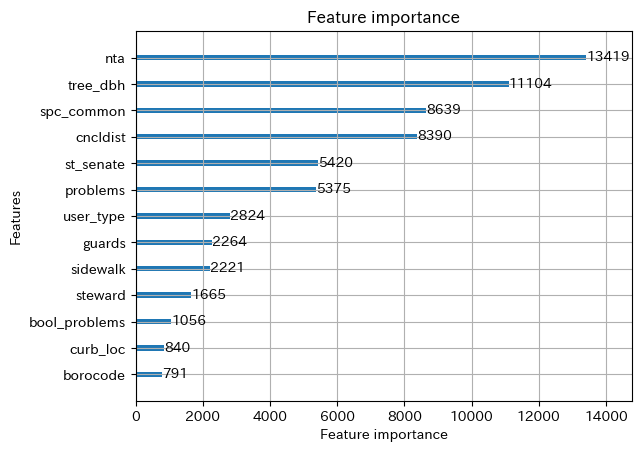

In [489]:
scores(model, X_eval, y_eval)

In [455]:
submit_pross(model, select_test_df)

## metric: multi_errorの場合（early_stop=100）

In [483]:
print('ベストスコア：', pre_model.best_score['valid_0'])
print('-'*30)
print('ベストイテレーション：', pre_model.best_iteration)
print('-'*30)
print('ベストパラメータ')
pre_model.params

ベストスコア： OrderedDict([('multi_error', 0.2690126751167445)])
------------------------------
ベストイテレーション： 392
------------------------------
ベストパラメータ


{'boosting_type': 'gbdt',
 'objective': 'multiclass',
 'metric': 'multi_error',
 'num_class': 3,
 'verbose': -1,
 'feature_pre_filter': False,
 'lambda_l1': 0.0,
 'lambda_l2': 0.0,
 'num_leaves': 253,
 'feature_fraction': 1.0,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 5,
 'num_iterations': 1000}

In [484]:
#チューニング後の予測
params = pre_model.params


#参照データ
X = select_train_df
y = val_df

#データ分割
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)


#lihgtGBMでの重み付け
train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
weighted_train = lgb.Dataset(X_train, y_train, weight=train_weight)
weighted_test = lgb.Dataset(X_eval, label=y_eval, reference=weighted_train)



#モデルのトレーニング
evals_result = {} 

model = lgb.train(
    params,
    weighted_train,
    valid_sets=weighted_test,
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=100),  lgb.record_evaluation(evals_result)])

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[392]	valid_0's multi_error: 0.269013


f1_score_score:0.3362215493692507
accuracy_score:0.7309873248832555
precision_score:0.3448732082594023
recall_score:0.3420944875663296


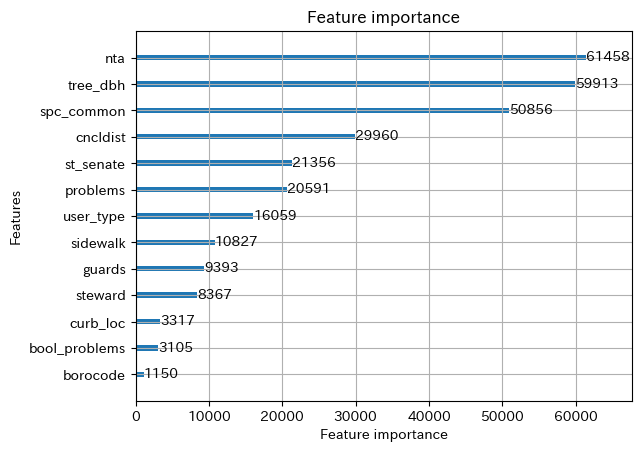

In [485]:
scores(model, X_eval, y_eval)

## LightGBMTunerCVを使用してパラメーターチューニング（StratifiedKFoldを使いたい）

In [460]:
from lightgbm import early_stopping
from lightgbm import log_evaluation

In [512]:
#参照データ
X = select_train_df
y = val_df

#データ分割
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)


#lihgtGBMでの重み付け
train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
trainval = lgbo.Dataset(X_train, y_train, weight=train_weight)



#探索用の最低限のパラメーター
params ={
    'boosting_type':'gbdt',
    'objective':'multiclass',
    'metric':'multi_logloss',
    'num_class':3,
    'verbosity':-1,
}



#目玉のCV設定
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

#チューナー設定
tuner = lgbo.LightGBMTunerCV(params, trainval, nfold=cv, callbacks=[early_stopping(100)])

#パラメーター探索の実行
tuner.run()

[I 2023-12-28 15:54:30,128] A new study created in memory with name: no-name-d48b3e9e-c274-43f0-afd7-621a3b3bdd45



  0%|          | 0/7 [00:00<?, ?it/s]


feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds





feature_fraction, val_score: 1.090780:   0%|          | 0/7 [00:03<?, ?it/s]


feature_fraction, val_score: 1.090780:  14%|#4        | 1/7 [00:03<00:20,  3.49s/it][I 2023-12-28 15:54:33,645] Trial 0 finished with value: 1.0907802191081573 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 1.0907802191081573.



feature_fraction, val_score: 1.090780:  14%|#4        | 1/7 [00:03<00:20,  3.49s/it]

Early stopping, best iteration is:
[4]	cv_agg's valid multi_logloss: 1.09078 + 0.00543007
Training until validation scores don't improve for 100 rounds





feature_fraction, val_score: 1.089123:  14%|#4        | 1/7 [00:06<00:20,  3.49s/it]


feature_fraction, val_score: 1.089123:  29%|##8       | 2/7 [00:06<00:16,  3.33s/it][I 2023-12-28 15:54:36,867] Trial 1 finished with value: 1.0891230048689138 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 1.0891230048689138.



feature_fraction, val_score: 1.089123:  29%|##8       | 2/7 [00:06<00:16,  3.33s/it]

Early stopping, best iteration is:
[3]	cv_agg's valid multi_logloss: 1.08912 + 0.0029962
Training until validation scores don't improve for 100 rounds





feature_fraction, val_score: 1.089123:  29%|##8       | 2/7 [00:10<00:16,  3.33s/it]


feature_fraction, val_score: 1.089123:  43%|####2     | 3/7 [00:10<00:13,  3.46s/it][I 2023-12-28 15:54:40,489] Trial 2 finished with value: 1.0918912361256632 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 1.0891230048689138.



feature_fraction, val_score: 1.089123:  43%|####2     | 3/7 [00:10<00:13,  3.46s/it]

Early stopping, best iteration is:
[4]	cv_agg's valid multi_logloss: 1.09189 + 0.00443107
Training until validation scores don't improve for 100 rounds





feature_fraction, val_score: 1.085183:  43%|####2     | 3/7 [00:13<00:13,  3.46s/it]


feature_fraction, val_score: 1.085183:  57%|#####7    | 4/7 [00:13<00:10,  3.42s/it][I 2023-12-28 15:54:43,830] Trial 3 finished with value: 1.085182639164566 and parameters: {'feature_fraction': 0.4}. Best is trial 3 with value: 1.085182639164566.



feature_fraction, val_score: 1.085183:  57%|#####7    | 4/7 [00:13<00:10,  3.42s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.08518 + 0.00255052
Training until validation scores don't improve for 100 rounds





feature_fraction, val_score: 1.085183:  57%|#####7    | 4/7 [00:16<00:10,  3.42s/it]


feature_fraction, val_score: 1.085183:  71%|#######1  | 5/7 [00:16<00:06,  3.33s/it][I 2023-12-28 15:54:47,004] Trial 4 finished with value: 1.0915623085672799 and parameters: {'feature_fraction': 0.7}. Best is trial 3 with value: 1.085182639164566.



feature_fraction, val_score: 1.085183:  71%|#######1  | 5/7 [00:16<00:06,  3.33s/it]

Early stopping, best iteration is:
[3]	cv_agg's valid multi_logloss: 1.09156 + 0.00418148
Training until validation scores don't improve for 100 rounds





feature_fraction, val_score: 1.085183:  71%|#######1  | 5/7 [00:20<00:06,  3.33s/it]


feature_fraction, val_score: 1.085183:  86%|########5 | 6/7 [00:20<00:03,  3.35s/it][I 2023-12-28 15:54:50,411] Trial 5 finished with value: 1.090403481660377 and parameters: {'feature_fraction': 1.0}. Best is trial 3 with value: 1.085182639164566.



feature_fraction, val_score: 1.085183:  86%|########5 | 6/7 [00:20<00:03,  3.35s/it]

Early stopping, best iteration is:
[2]	cv_agg's valid multi_logloss: 1.0904 + 0.00345759
Training until validation scores don't improve for 100 rounds





feature_fraction, val_score: 1.085183:  86%|########5 | 6/7 [00:23<00:03,  3.35s/it]


feature_fraction, val_score: 1.085183: 100%|##########| 7/7 [00:23<00:00,  3.39s/it]


Early stopping, best iteration is:
[3]	cv_agg's valid multi_logloss: 1.09106 + 0.00431947





  0%|          | 0/20 [00:00<?, ?it/s]


num_leaves, val_score: 1.085183:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.085183:   0%|          | 0/20 [00:08<?, ?it/s]


num_leaves, val_score: 1.085183:   5%|5         | 1/20 [00:08<02:39,  8.37s/it][I 2023-12-28 15:55:02,255] Trial 7 finished with value: 1.0876933385842034 and parameters: {'num_leaves': 235}. Best is trial 7 with value: 1.0876933385842034.



num_leaves, val_score: 1.085183:   5%|5         | 1/20 [00:08<02:39,  8.37s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.08769 + 0.00296137
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.085183:   5%|5         | 1/20 [00:20<02:39,  8.37s/it]


num_leaves, val_score: 1.085183:  10%|#         | 2/20 [00:20<03:14, 10.82s/it][I 2023-12-28 15:55:14,785] Trial 8 finished with value: 1.0875864323411144 and parameters: {'num_leaves': 186}. Best is trial 8 with value: 1.0875864323411144.



num_leaves, val_score: 1.085183:  10%|#         | 2/20 [00:20<03:14, 10.82s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.08759 + 0.00335754
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  10%|#         | 2/20 [00:23<03:14, 10.82s/it]


num_leaves, val_score: 1.079860:  15%|#5        | 3/20 [00:23<01:57,  6.93s/it][I 2023-12-28 15:55:17,097] Trial 9 finished with value: 1.0798596132031486 and parameters: {'num_leaves': 2}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  15%|#5        | 3/20 [00:23<01:57,  6.93s/it]

Early stopping, best iteration is:
[23]	cv_agg's valid multi_logloss: 1.07986 + 0.00677181
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  15%|#5        | 3/20 [00:25<01:57,  6.93s/it]


num_leaves, val_score: 1.079860:  20%|##        | 4/20 [00:25<01:21,  5.06s/it][I 2023-12-28 15:55:19,297] Trial 10 finished with value: 1.0798842379149267 and parameters: {'num_leaves': 3}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  20%|##        | 4/20 [00:25<01:21,  5.06s/it]

Early stopping, best iteration is:
[17]	cv_agg's valid multi_logloss: 1.07988 + 0.0062746
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  20%|##        | 4/20 [00:26<01:21,  5.06s/it]


num_leaves, val_score: 1.079860:  25%|##5       | 5/20 [00:26<00:56,  3.73s/it][I 2023-12-28 15:55:20,668] Trial 11 finished with value: 1.0809873487560373 and parameters: {'num_leaves': 4}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  25%|##5       | 5/20 [00:26<00:56,  3.73s/it]

Early stopping, best iteration is:
[16]	cv_agg's valid multi_logloss: 1.08099 + 0.00722811
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  25%|##5       | 5/20 [00:28<00:56,  3.73s/it]


num_leaves, val_score: 1.079860:  30%|###       | 6/20 [00:28<00:43,  3.10s/it][I 2023-12-28 15:55:22,553] Trial 12 finished with value: 1.083815017902591 and parameters: {'num_leaves': 9}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  30%|###       | 6/20 [00:28<00:43,  3.10s/it]

Early stopping, best iteration is:
[13]	cv_agg's valid multi_logloss: 1.08382 + 0.00505777
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  30%|###       | 6/20 [00:33<00:43,  3.10s/it]


num_leaves, val_score: 1.079860:  35%|###5      | 7/20 [00:33<00:49,  3.78s/it][I 2023-12-28 15:55:27,735] Trial 13 finished with value: 1.0863929061974669 and parameters: {'num_leaves': 74}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  35%|###5      | 7/20 [00:33<00:49,  3.78s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.08639 + 0.00183585
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  35%|###5      | 7/20 [00:39<00:49,  3.78s/it]


num_leaves, val_score: 1.079860:  40%|####      | 8/20 [00:39<00:52,  4.35s/it][I 2023-12-28 15:55:33,283] Trial 14 finished with value: 1.0868284384555755 and parameters: {'num_leaves': 77}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  40%|####      | 8/20 [00:39<00:52,  4.35s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.08683 + 0.0019337
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  40%|####      | 8/20 [00:44<00:52,  4.35s/it]


num_leaves, val_score: 1.079860:  45%|####5     | 9/20 [00:44<00:51,  4.70s/it][I 2023-12-28 15:55:38,752] Trial 15 finished with value: 1.085885256958491 and parameters: {'num_leaves': 66}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  45%|####5     | 9/20 [00:44<00:51,  4.70s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.08589 + 0.00287396
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  45%|####5     | 9/20 [00:47<00:51,  4.70s/it]


num_leaves, val_score: 1.079860:  50%|#####     | 10/20 [00:47<00:39,  3.98s/it][I 2023-12-28 15:55:41,122] Trial 16 finished with value: 1.083815017902591 and parameters: {'num_leaves': 9}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  50%|#####     | 10/20 [00:47<00:39,  3.98s/it]

Early stopping, best iteration is:
[13]	cv_agg's valid multi_logloss: 1.08382 + 0.00505777
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  50%|#####     | 10/20 [00:56<00:39,  3.98s/it]


num_leaves, val_score: 1.079860:  55%|#####5    | 11/20 [00:56<00:49,  5.49s/it][I 2023-12-28 15:55:50,041] Trial 17 finished with value: 1.0868657244719302 and parameters: {'num_leaves': 127}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  55%|#####5    | 11/20 [00:56<00:49,  5.49s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.08687 + 0.00200422
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  55%|#####5    | 11/20 [01:02<00:49,  5.49s/it]


num_leaves, val_score: 1.079860:  60%|######    | 12/20 [01:02<00:45,  5.70s/it][I 2023-12-28 15:55:56,231] Trial 18 finished with value: 1.0862628411870525 and parameters: {'num_leaves': 54}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  60%|######    | 12/20 [01:02<00:45,  5.70s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.08626 + 0.00221614
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  60%|######    | 12/20 [01:14<00:45,  5.70s/it]


num_leaves, val_score: 1.079860:  65%|######5   | 13/20 [01:14<00:54,  7.79s/it][I 2023-12-28 15:56:08,806] Trial 19 finished with value: 1.0873678867492722 and parameters: {'num_leaves': 125}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  65%|######5   | 13/20 [01:14<00:54,  7.79s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.08737 + 0.0024151
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  65%|######5   | 13/20 [01:19<00:54,  7.79s/it]


num_leaves, val_score: 1.079860:  70%|#######   | 14/20 [01:19<00:40,  6.78s/it][I 2023-12-28 15:56:13,262] Trial 20 finished with value: 1.085501948865627 and parameters: {'num_leaves': 40}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  70%|#######   | 14/20 [01:19<00:40,  6.78s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.0855 + 0.00248559
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  70%|#######   | 14/20 [01:20<00:40,  6.78s/it]


num_leaves, val_score: 1.079860:  75%|#######5  | 15/20 [01:20<00:26,  5.21s/it][I 2023-12-28 15:56:14,849] Trial 21 finished with value: 1.0798842379149267 and parameters: {'num_leaves': 3}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  75%|#######5  | 15/20 [01:20<00:26,  5.21s/it]

Early stopping, best iteration is:
[17]	cv_agg's valid multi_logloss: 1.07988 + 0.0062746
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  75%|#######5  | 15/20 [01:25<00:26,  5.21s/it]


num_leaves, val_score: 1.079860:  80%|########  | 16/20 [01:25<00:19,  4.89s/it][I 2023-12-28 15:56:18,982] Trial 22 finished with value: 1.0854415310152024 and parameters: {'num_leaves': 32}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  80%|########  | 16/20 [01:25<00:19,  4.89s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.08544 + 0.00258634
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  80%|########  | 16/20 [01:31<00:19,  4.89s/it]


num_leaves, val_score: 1.079860:  85%|########5 | 17/20 [01:31<00:16,  5.37s/it][I 2023-12-28 15:56:25,474] Trial 23 finished with value: 1.0861248695213088 and parameters: {'num_leaves': 98}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  85%|########5 | 17/20 [01:31<00:16,  5.37s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.08612 + 0.00176452
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  85%|########5 | 17/20 [01:34<00:16,  5.37s/it]


num_leaves, val_score: 1.079860:  90%|######### | 18/20 [01:34<00:09,  4.66s/it][I 2023-12-28 15:56:28,493] Trial 24 finished with value: 1.0849849534636953 and parameters: {'num_leaves': 27}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  90%|######### | 18/20 [01:34<00:09,  4.66s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.08498 + 0.00242654
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  90%|######### | 18/20 [01:42<00:09,  4.66s/it]


num_leaves, val_score: 1.079860:  95%|#########5| 19/20 [01:42<00:05,  5.77s/it][I 2023-12-28 15:56:36,845] Trial 25 finished with value: 1.0872583705392227 and parameters: {'num_leaves': 182}. Best is trial 9 with value: 1.0798596132031486.



num_leaves, val_score: 1.079860:  95%|#########5| 19/20 [01:42<00:05,  5.77s/it]

Early stopping, best iteration is:
[5]	cv_agg's valid multi_logloss: 1.08726 + 0.00296449
Training until validation scores don't improve for 100 rounds





num_leaves, val_score: 1.079860:  95%|#########5| 19/20 [01:44<00:05,  5.77s/it]


num_leaves, val_score: 1.079860: 100%|##########| 20/20 [01:44<00:00,  5.21s/it]


Early stopping, best iteration is:
[17]	cv_agg's valid multi_logloss: 1.07988 + 0.0062746





  0%|          | 0/10 [00:00<?, ?it/s]


bagging, val_score: 1.079860:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds





bagging, val_score: 1.079860:   0%|          | 0/10 [00:01<?, ?it/s]


bagging, val_score: 1.079860:  10%|#         | 1/10 [00:01<00:09,  1.01s/it][I 2023-12-28 15:56:39,092] Trial 27 finished with value: 1.0885264382904984 and parameters: {'bagging_fraction': 0.42606046836187317, 'bagging_freq': 3}. Best is trial 27 with value: 1.0885264382904984.



bagging, val_score: 1.079860:  10%|#         | 1/10 [00:01<00:09,  1.01s/it]

Early stopping, best iteration is:
[13]	cv_agg's valid multi_logloss: 1.08853 + 0.00298326
Training until validation scores don't improve for 100 rounds





bagging, val_score: 1.079788:  10%|#         | 1/10 [00:02<00:09,  1.01s/it]


bagging, val_score: 1.079788:  20%|##        | 2/10 [00:02<00:10,  1.26s/it][I 2023-12-28 15:56:40,528] Trial 28 finished with value: 1.0797877470389718 and parameters: {'bagging_fraction': 0.9932486353468164, 'bagging_freq': 7}. Best is trial 28 with value: 1.0797877470389718.



bagging, val_score: 1.079788:  20%|##        | 2/10 [00:02<00:10,  1.26s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07979 + 0.00657075
Training until validation scores don't improve for 100 rounds





bagging, val_score: 1.079788:  20%|##        | 2/10 [00:04<00:10,  1.26s/it]


bagging, val_score: 1.079788:  30%|###       | 3/10 [00:04<00:09,  1.43s/it][I 2023-12-28 15:56:42,151] Trial 29 finished with value: 1.080081787997979 and parameters: {'bagging_fraction': 0.9976114039842391, 'bagging_freq': 7}. Best is trial 28 with value: 1.0797877470389718.



bagging, val_score: 1.079788:  30%|###       | 3/10 [00:04<00:09,  1.43s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.08008 + 0.00762521
Training until validation scores don't improve for 100 rounds





bagging, val_score: 1.079788:  30%|###       | 3/10 [00:05<00:09,  1.43s/it]


bagging, val_score: 1.079788:  40%|####      | 4/10 [00:05<00:08,  1.47s/it][I 2023-12-28 15:56:43,693] Trial 30 finished with value: 1.0800840217521015 and parameters: {'bagging_fraction': 0.9949099604129629, 'bagging_freq': 7}. Best is trial 28 with value: 1.0797877470389718.



bagging, val_score: 1.079788:  40%|####      | 4/10 [00:05<00:08,  1.47s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.08008 + 0.00716932
Training until validation scores don't improve for 100 rounds





bagging, val_score: 1.079788:  40%|####      | 4/10 [00:06<00:08,  1.47s/it]


bagging, val_score: 1.079788:  50%|#####     | 5/10 [00:06<00:06,  1.39s/it][I 2023-12-28 15:56:44,945] Trial 31 finished with value: 1.0843059894450973 and parameters: {'bagging_fraction': 0.7692238798264861, 'bagging_freq': 1}. Best is trial 28 with value: 1.0797877470389718.



bagging, val_score: 1.079788:  50%|#####     | 5/10 [00:06<00:06,  1.39s/it]

Early stopping, best iteration is:
[17]	cv_agg's valid multi_logloss: 1.08431 + 0.00385041
Training until validation scores don't improve for 100 rounds





bagging, val_score: 1.079788:  50%|#####     | 5/10 [00:07<00:06,  1.39s/it]


bagging, val_score: 1.079788:  60%|######    | 6/10 [00:07<00:05,  1.30s/it][I 2023-12-28 15:56:46,071] Trial 32 finished with value: 1.082032490570975 and parameters: {'bagging_fraction': 0.7879613015670754, 'bagging_freq': 5}. Best is trial 28 with value: 1.0797877470389718.



bagging, val_score: 1.079788:  60%|######    | 6/10 [00:07<00:05,  1.30s/it]

Early stopping, best iteration is:
[23]	cv_agg's valid multi_logloss: 1.08203 + 0.00603575
Training until validation scores don't improve for 100 rounds





bagging, val_score: 1.079788:  60%|######    | 6/10 [00:09<00:05,  1.30s/it]


bagging, val_score: 1.079788:  70%|#######   | 7/10 [00:09<00:03,  1.29s/it][I 2023-12-28 15:56:47,345] Trial 33 finished with value: 1.0810422340340962 and parameters: {'bagging_fraction': 0.8546490954983746, 'bagging_freq': 5}. Best is trial 28 with value: 1.0797877470389718.



bagging, val_score: 1.079788:  70%|#######   | 7/10 [00:09<00:03,  1.29s/it]

Early stopping, best iteration is:
[21]	cv_agg's valid multi_logloss: 1.08104 + 0.00512657
Training until validation scores don't improve for 100 rounds





bagging, val_score: 1.079788:  70%|#######   | 7/10 [00:10<00:03,  1.29s/it]


bagging, val_score: 1.079788:  80%|########  | 8/10 [00:10<00:02,  1.26s/it][I 2023-12-28 15:56:48,534] Trial 34 finished with value: 1.0865241128788088 and parameters: {'bagging_fraction': 0.644642458619253, 'bagging_freq': 3}. Best is trial 28 with value: 1.0797877470389718.



bagging, val_score: 1.079788:  80%|########  | 8/10 [00:10<00:02,  1.26s/it]

Early stopping, best iteration is:
[16]	cv_agg's valid multi_logloss: 1.08652 + 0.00231278
Training until validation scores don't improve for 100 rounds





bagging, val_score: 1.079788:  80%|########  | 8/10 [00:11<00:02,  1.26s/it]


bagging, val_score: 1.079788:  90%|######### | 9/10 [00:11<00:01,  1.20s/it][I 2023-12-28 15:56:49,608] Trial 35 finished with value: 1.0852899075945308 and parameters: {'bagging_fraction': 0.6365563229892091, 'bagging_freq': 6}. Best is trial 28 with value: 1.0797877470389718.



bagging, val_score: 1.079788:  90%|######### | 9/10 [00:11<00:01,  1.20s/it]

Early stopping, best iteration is:
[16]	cv_agg's valid multi_logloss: 1.08529 + 0.00297001
Training until validation scores don't improve for 100 rounds





bagging, val_score: 1.079788:  90%|######### | 9/10 [00:12<00:01,  1.20s/it]


bagging, val_score: 1.079788: 100%|##########| 10/10 [00:12<00:00,  1.27s/it]


Early stopping, best iteration is:
[21]	cv_agg's valid multi_logloss: 1.08102 + 0.00509935





  0%|          | 0/3 [00:00<?, ?it/s]


feature_fraction_stage2, val_score: 1.079788:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds





feature_fraction_stage2, val_score: 1.079788:   0%|          | 0/3 [00:01<?, ?it/s]


feature_fraction_stage2, val_score: 1.079788:  33%|###3      | 1/3 [00:01<00:02,  1.40s/it][I 2023-12-28 15:56:52,165] Trial 37 finished with value: 1.0818389874032026 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 1.0818389874032026.



feature_fraction_stage2, val_score: 1.079788:  33%|###3      | 1/3 [00:01<00:02,  1.40s/it]

Early stopping, best iteration is:
[31]	cv_agg's valid multi_logloss: 1.08184 + 0.00695452
Training until validation scores don't improve for 100 rounds





feature_fraction_stage2, val_score: 1.079788:  33%|###3      | 1/3 [00:02<00:02,  1.40s/it]


feature_fraction_stage2, val_score: 1.079788:  67%|######6   | 2/3 [00:02<00:01,  1.51s/it][I 2023-12-28 15:56:53,753] Trial 38 finished with value: 1.0818389874032026 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 1.0818389874032026.



feature_fraction_stage2, val_score: 1.079788:  67%|######6   | 2/3 [00:03<00:01,  1.51s/it]

Early stopping, best iteration is:
[31]	cv_agg's valid multi_logloss: 1.08184 + 0.00695452
Training until validation scores don't improve for 100 rounds





feature_fraction_stage2, val_score: 1.079788:  67%|######6   | 2/3 [00:04<00:01,  1.51s/it]


feature_fraction_stage2, val_score: 1.079788: 100%|##########| 3/3 [00:04<00:00,  1.44s/it]


Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07979 + 0.00657075





  0%|          | 0/20 [00:00<?, ?it/s]


regularization_factors, val_score: 1.079788:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079787:   0%|          | 0/20 [00:01<?, ?it/s]


regularization_factors, val_score: 1.079787:   5%|5         | 1/20 [00:01<00:29,  1.56s/it][I 2023-12-28 15:56:56,643] Trial 40 finished with value: 1.0797873321734568 and parameters: {'lambda_l1': 3.339604838360883e-07, 'lambda_l2': 0.04532735029381254}. Best is trial 40 with value: 1.0797873321734568.



regularization_factors, val_score: 1.079787:   5%|5         | 1/20 [00:01<00:29,  1.56s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07979 + 0.00657019
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079787:   5%|5         | 1/20 [00:02<00:29,  1.56s/it]


regularization_factors, val_score: 1.079787:  10%|#         | 2/20 [00:02<00:25,  1.43s/it][I 2023-12-28 15:56:57,993] Trial 41 finished with value: 1.0797869517794794 and parameters: {'lambda_l1': 1.3719745493044053e-07, 'lambda_l2': 0.08691319257112744}. Best is trial 41 with value: 1.0797869517794794.



regularization_factors, val_score: 1.079787:  10%|#         | 2/20 [00:02<00:25,  1.43s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07979 + 0.00656967
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079787:  10%|#         | 2/20 [00:04<00:25,  1.43s/it]


regularization_factors, val_score: 1.079787:  15%|#5        | 3/20 [00:04<00:23,  1.39s/it][I 2023-12-28 15:56:59,321] Trial 42 finished with value: 1.079786891717363 and parameters: {'lambda_l1': 9.252895194229042e-08, 'lambda_l2': 0.09347992492951959}. Best is trial 42 with value: 1.079786891717363.



regularization_factors, val_score: 1.079787:  15%|#5        | 3/20 [00:04<00:23,  1.39s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07979 + 0.00656958
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079787:  15%|#5        | 3/20 [00:05<00:23,  1.39s/it]


regularization_factors, val_score: 1.079787:  20%|##        | 4/20 [00:05<00:22,  1.40s/it][I 2023-12-28 15:57:00,750] Trial 43 finished with value: 1.080060358548179 and parameters: {'lambda_l1': 8.835195397989762e-08, 'lambda_l2': 0.12645444268085781}. Best is trial 42 with value: 1.079786891717363.



regularization_factors, val_score: 1.079787:  20%|##        | 4/20 [00:05<00:22,  1.40s/it]

Early stopping, best iteration is:
[27]	cv_agg's valid multi_logloss: 1.08006 + 0.00643125
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079787:  20%|##        | 4/20 [00:06<00:22,  1.40s/it]


regularization_factors, val_score: 1.079787:  25%|##5       | 5/20 [00:06<00:20,  1.36s/it][I 2023-12-28 15:57:02,035] Trial 44 finished with value: 1.0797874586594054 and parameters: {'lambda_l1': 9.563496119286713e-08, 'lambda_l2': 0.03150563261832602}. Best is trial 42 with value: 1.079786891717363.



regularization_factors, val_score: 1.079787:  25%|##5       | 5/20 [00:06<00:20,  1.36s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07979 + 0.00657036
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079787:  25%|##5       | 5/20 [00:08<00:20,  1.36s/it]


regularization_factors, val_score: 1.079787:  30%|###       | 6/20 [00:08<00:19,  1.39s/it][I 2023-12-28 15:57:03,473] Trial 45 finished with value: 1.0797873729171577 and parameters: {'lambda_l1': 8.346695310730815e-08, 'lambda_l2': 0.04087144039618585}. Best is trial 42 with value: 1.079786891717363.



regularization_factors, val_score: 1.079787:  30%|###       | 6/20 [00:08<00:19,  1.39s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07979 + 0.00657024
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079787:  30%|###       | 6/20 [00:09<00:19,  1.39s/it]


regularization_factors, val_score: 1.079787:  35%|###5      | 7/20 [00:09<00:18,  1.42s/it][I 2023-12-28 15:57:04,960] Trial 46 finished with value: 1.079787225251414 and parameters: {'lambda_l1': 1.0126761793512992e-07, 'lambda_l2': 0.057010683569336675}. Best is trial 42 with value: 1.079786891717363.



regularization_factors, val_score: 1.079787:  35%|###5      | 7/20 [00:09<00:18,  1.42s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07979 + 0.00657004
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079787:  35%|###5      | 7/20 [00:11<00:18,  1.42s/it]


regularization_factors, val_score: 1.079787:  40%|####      | 8/20 [00:11<00:17,  1.42s/it][I 2023-12-28 15:57:06,384] Trial 47 finished with value: 1.0797872373109882 and parameters: {'lambda_l1': 1.1289160405551774e-07, 'lambda_l2': 0.055693914296143}. Best is trial 42 with value: 1.079786891717363.



regularization_factors, val_score: 1.079787:  40%|####      | 8/20 [00:11<00:17,  1.42s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07979 + 0.00657006
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079787:  40%|####      | 8/20 [00:12<00:17,  1.42s/it]


regularization_factors, val_score: 1.079787:  45%|####5     | 9/20 [00:12<00:14,  1.36s/it][I 2023-12-28 15:57:07,607] Trial 48 finished with value: 1.0797868946521076 and parameters: {'lambda_l1': 1.3962022788459746e-07, 'lambda_l2': 0.09315738192127901}. Best is trial 42 with value: 1.079786891717363.



regularization_factors, val_score: 1.079787:  45%|####5     | 9/20 [00:12<00:14,  1.36s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07979 + 0.00656959
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079787:  45%|####5     | 9/20 [00:14<00:14,  1.36s/it]


regularization_factors, val_score: 1.079787:  50%|#####     | 10/20 [00:14<00:15,  1.54s/it][I 2023-12-28 15:57:09,555] Trial 49 finished with value: 1.0800601976015123 and parameters: {'lambda_l1': 1.5497737590079684e-07, 'lambda_l2': 0.1479193783844507}. Best is trial 42 with value: 1.079786891717363.



regularization_factors, val_score: 1.079787:  50%|#####     | 10/20 [00:14<00:15,  1.54s/it]

Early stopping, best iteration is:
[27]	cv_agg's valid multi_logloss: 1.08006 + 0.006431
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079368:  50%|#####     | 10/20 [00:15<00:15,  1.54s/it]


regularization_factors, val_score: 1.079368:  55%|#####5    | 11/20 [00:15<00:13,  1.48s/it][I 2023-12-28 15:57:10,913] Trial 50 finished with value: 1.079368267622708 and parameters: {'lambda_l1': 0.007793829127041855, 'lambda_l2': 4.987829252453812}. Best is trial 50 with value: 1.079368267622708.



regularization_factors, val_score: 1.079368:  55%|#####5    | 11/20 [00:15<00:13,  1.48s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07937 + 0.00673972
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079131:  55%|#####5    | 11/20 [00:17<00:13,  1.48s/it]


regularization_factors, val_score: 1.079131:  60%|######    | 12/20 [00:17<00:12,  1.51s/it][I 2023-12-28 15:57:12,490] Trial 51 finished with value: 1.0791313169162815 and parameters: {'lambda_l1': 0.004141794964690501, 'lambda_l2': 9.570192512640041}. Best is trial 51 with value: 1.0791313169162815.



regularization_factors, val_score: 1.079131:  60%|######    | 12/20 [00:17<00:12,  1.51s/it]

Early stopping, best iteration is:
[27]	cv_agg's valid multi_logloss: 1.07913 + 0.00646642
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079131:  60%|######    | 12/20 [00:18<00:12,  1.51s/it]


regularization_factors, val_score: 1.079131:  65%|######5   | 13/20 [00:18<00:10,  1.49s/it][I 2023-12-28 15:57:13,935] Trial 52 finished with value: 1.079331828369234 and parameters: {'lambda_l1': 0.010834191137829999, 'lambda_l2': 6.870064010223949}. Best is trial 51 with value: 1.0791313169162815.



regularization_factors, val_score: 1.079131:  65%|######5   | 13/20 [00:18<00:10,  1.49s/it]

Early stopping, best iteration is:
[27]	cv_agg's valid multi_logloss: 1.07933 + 0.00637711
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079131:  65%|######5   | 13/20 [00:20<00:10,  1.49s/it]


regularization_factors, val_score: 1.079131:  70%|#######   | 14/20 [00:20<00:08,  1.46s/it][I 2023-12-28 15:57:15,304] Trial 53 finished with value: 1.079200314697808 and parameters: {'lambda_l1': 0.006968910406716092, 'lambda_l2': 8.301859967277174}. Best is trial 51 with value: 1.0791313169162815.



regularization_factors, val_score: 1.079131:  70%|#######   | 14/20 [00:20<00:08,  1.46s/it]

Early stopping, best iteration is:
[27]	cv_agg's valid multi_logloss: 1.0792 + 0.00638677
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079131:  70%|#######   | 14/20 [00:21<00:08,  1.46s/it]


regularization_factors, val_score: 1.079131:  75%|#######5  | 15/20 [00:21<00:07,  1.51s/it][I 2023-12-28 15:57:16,933] Trial 54 finished with value: 1.0792042201188814 and parameters: {'lambda_l1': 0.006739175986583156, 'lambda_l2': 8.749805299338613}. Best is trial 51 with value: 1.0791313169162815.



regularization_factors, val_score: 1.079131:  75%|#######5  | 15/20 [00:21<00:07,  1.51s/it]

Early stopping, best iteration is:
[27]	cv_agg's valid multi_logloss: 1.0792 + 0.00637861
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079093:  75%|#######5  | 15/20 [00:23<00:07,  1.51s/it]


regularization_factors, val_score: 1.079093:  80%|########  | 16/20 [00:23<00:05,  1.46s/it][I 2023-12-28 15:57:18,265] Trial 55 finished with value: 1.0790925928696484 and parameters: {'lambda_l1': 0.009130212758948495, 'lambda_l2': 9.375459794770714}. Best is trial 55 with value: 1.0790925928696484.



regularization_factors, val_score: 1.079093:  80%|########  | 16/20 [00:23<00:05,  1.46s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07909 + 0.00680562
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079093:  80%|########  | 16/20 [00:24<00:05,  1.46s/it]


regularization_factors, val_score: 1.079093:  85%|########5 | 17/20 [00:24<00:04,  1.39s/it][I 2023-12-28 15:57:19,506] Trial 56 finished with value: 1.0793684613830081 and parameters: {'lambda_l1': 0.015497844818209781, 'lambda_l2': 4.959845039542897}. Best is trial 55 with value: 1.0790925928696484.



regularization_factors, val_score: 1.079093:  85%|########5 | 17/20 [00:24<00:04,  1.39s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07937 + 0.00673983
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079093:  85%|########5 | 17/20 [00:25<00:04,  1.39s/it]


regularization_factors, val_score: 1.079093:  90%|######### | 18/20 [00:25<00:02,  1.36s/it][I 2023-12-28 15:57:20,785] Trial 57 finished with value: 1.0791771312117167 and parameters: {'lambda_l1': 0.009766962000396796, 'lambda_l2': 9.06249209180473}. Best is trial 55 with value: 1.0790925928696484.



regularization_factors, val_score: 1.079093:  90%|######### | 18/20 [00:25<00:02,  1.36s/it]

Early stopping, best iteration is:
[27]	cv_agg's valid multi_logloss: 1.07918 + 0.00639205
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079093:  90%|######### | 18/20 [00:27<00:02,  1.36s/it]


regularization_factors, val_score: 1.079093:  95%|#########5| 19/20 [00:27<00:01,  1.38s/it][I 2023-12-28 15:57:22,209] Trial 58 finished with value: 1.0792003272270294 and parameters: {'lambda_l1': 0.0046672948540060506, 'lambda_l2': 8.300261781909482}. Best is trial 55 with value: 1.0790925928696484.



regularization_factors, val_score: 1.079093:  95%|#########5| 19/20 [00:27<00:01,  1.38s/it]

Early stopping, best iteration is:
[27]	cv_agg's valid multi_logloss: 1.0792 + 0.00638685
Training until validation scores don't improve for 100 rounds





regularization_factors, val_score: 1.079092:  95%|#########5| 19/20 [00:30<00:01,  1.38s/it]


regularization_factors, val_score: 1.079092: 100%|##########| 20/20 [00:30<00:00,  1.50s/it]


Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07909 + 0.00680478





  0%|          | 0/5 [00:00<?, ?it/s]


min_child_samples, val_score: 1.079092:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds





min_child_samples, val_score: 1.079092:   0%|          | 0/5 [00:01<?, ?it/s]


min_child_samples, val_score: 1.079092:  20%|##        | 1/5 [00:01<00:06,  1.72s/it][I 2023-12-28 15:57:26,910] Trial 60 finished with value: 1.0790918893298096 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 1.0790918893298096.



min_child_samples, val_score: 1.079092:  20%|##        | 1/5 [00:01<00:06,  1.72s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07909 + 0.00680478
Training until validation scores don't improve for 100 rounds





min_child_samples, val_score: 1.079092:  20%|##        | 1/5 [00:03<00:06,  1.72s/it]


min_child_samples, val_score: 1.079092:  40%|####      | 2/5 [00:03<00:05,  1.68s/it][I 2023-12-28 15:57:28,549] Trial 61 finished with value: 1.0790918893298096 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 1.0790918893298096.



min_child_samples, val_score: 1.079092:  40%|####      | 2/5 [00:03<00:05,  1.68s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07909 + 0.00680478
Training until validation scores don't improve for 100 rounds





min_child_samples, val_score: 1.079092:  40%|####      | 2/5 [00:04<00:05,  1.68s/it]


min_child_samples, val_score: 1.079092:  60%|######    | 3/5 [00:04<00:03,  1.63s/it][I 2023-12-28 15:57:30,125] Trial 62 finished with value: 1.0790918893298096 and parameters: {'min_child_samples': 10}. Best is trial 60 with value: 1.0790918893298096.



min_child_samples, val_score: 1.079092:  60%|######    | 3/5 [00:04<00:03,  1.63s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07909 + 0.00680478
Training until validation scores don't improve for 100 rounds





min_child_samples, val_score: 1.079092:  60%|######    | 3/5 [00:06<00:03,  1.63s/it]


min_child_samples, val_score: 1.079092:  80%|########  | 4/5 [00:06<00:01,  1.54s/it][I 2023-12-28 15:57:31,523] Trial 63 finished with value: 1.0790918893298096 and parameters: {'min_child_samples': 25}. Best is trial 60 with value: 1.0790918893298096.



min_child_samples, val_score: 1.079092:  80%|########  | 4/5 [00:06<00:01,  1.54s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07909 + 0.00680478
Training until validation scores don't improve for 100 rounds





min_child_samples, val_score: 1.079092:  80%|########  | 4/5 [00:07<00:01,  1.54s/it]


min_child_samples, val_score: 1.079092: 100%|##########| 5/5 [00:07<00:00,  1.59s/it]

Early stopping, best iteration is:
[28]	cv_agg's valid multi_logloss: 1.07909 + 0.00680478


In [491]:
tuner.best_params

{'boosting_type': 'gbdt',
 'objective': 'multiclass',
 'metric': 'multi_logloss',
 'num_class': 3,
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 0.33946625742004943,
 'lambda_l2': 0.1826561384760263,
 'num_leaves': 2,
 'feature_fraction': 0.58,
 'bagging_fraction': 0.9942494087700924,
 'bagging_freq': 4,
 'min_child_samples': 50}

In [507]:
#チューニング後の予測
params = tuner.best_params


#参照データ
X = select_train_df
y = val_df

#データ分割
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)


#lihgtGBMでの重み付け
train_weight = compute_sample_weight(class_weight='balanced', y=y_train).astype('float32')
weighted_train = lgb.Dataset(X_train, y_train, weight=train_weight)
weighted_test = lgb.Dataset(X_eval, label=y_eval, reference=lgb_train)


#モデルのトレーニング
evals_result = {} 

model = lgb.train(
    params,
    weighted_train,
    valid_sets=weighted_test,
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=100),  lgb.record_evaluation(evals_result)])

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[716]	valid_0's multi_logloss: 1.07134


f1_score_score:0.27720231053687877
accuracy_score:0.3645763842561708
precision_score:0.3510397307097104
recall_score:0.3753116270832127


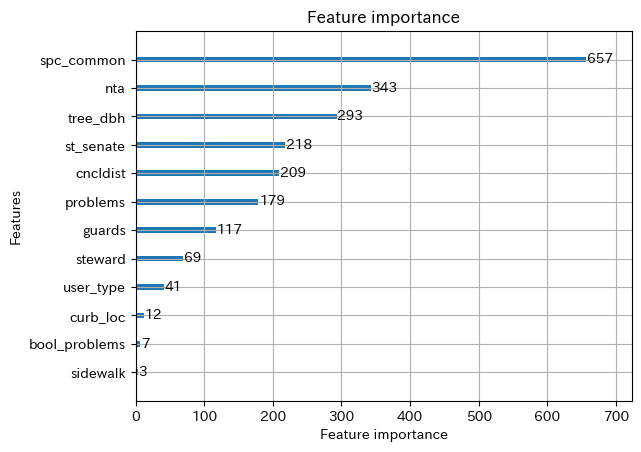

In [493]:
scores(model, X_eval, y_eval)

次の課題

・アンダーフィッティング
 →ラベルエンコーディングだけでなく、one-hotも使う -> モデルよりもデータが悪い可能性があるのでこれで改善？
 ->不均衡データの対応をする
 →次元削減　or 特徴量の削減　→アンダーサンプリングと重み付で不均衡の解消
 →時間があればターゲットエンコーディングを試す -> https://zenn.dev/y0/articles/5f76249012200a#tips-13%3A-%E4%B8%8D%E5%9D%87%E8%A1%A1%E3%83%87%E3%83%BC%E3%82%BF
